In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import functools

import matplotlib.pyplot as plt
import numpy as np
import os, pickle

import str_ww_util as util
import keras_model as models

from IPython import display


/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rng = np.random.default_rng(2024)

In [3]:
def convert_to_int16(sample_dict):
  audio = sample_dict['audio']
  label = sample_dict['label']
  audio16 = tf.cast(audio, 'int16')
  return audio16, label

def cast_and_pad(sample_dict):
  audio = sample_dict['audio']
  label = sample_dict['label']
  paddings = [[0, 16000-tf.shape(audio)[0]]]
  audio = tf.pad(audio, paddings)
  audio16 = tf.cast(audio, 'int16')
  return audio16, label

def convert_dataset(item):
  """Puts the mnist dataset in the format Keras expects, (features, labels)."""
  audio = item['audio']
  label = item['label']
  return audio, label


def get_preprocess_audio_func(model_settings,is_training=False,background_data = []):
  def prepare_processing_graph(next_element):
    """Builds a TensorFlow graph to apply the input distortions.
    Creates a graph that loads a WAVE file, decodes it, scales the volume,
    shifts it in time, adds in background noise, calculates a spectrogram, and
    then builds an MFCC fingerprint from that.
    This must be called with an active TensorFlow session running, and it
    creates multiple placeholder inputs, and one output:
      - wav_filename_placeholder_: Filename of the WAV to load.
      - foreground_volume_placeholder_: How loud the main clip should be.
      - time_shift_padding_placeholder_: Where to pad the clip.
      - time_shift_offset_placeholder_: How much to move the clip in time.
      - background_data_placeholder_: PCM sample data for background noise.
      - background_volume_placeholder_: Loudness of mixed-in background.
      - mfcc_: Output 2D fingerprint of processed audio.
    Args:
      model_settings: Information about the current model being trained.
    """
    desired_samples = model_settings['desired_samples']
    background_frequency = model_settings['background_frequency']
    background_volume_range_= model_settings['background_volume_range_']

    wav_decoder = tf.cast(next_element['audio'], tf.float32)
    if model_settings['feature_type'] != "td_samples":
      wav_decoder = wav_decoder/tf.reduce_max(wav_decoder)
    else:
      wav_decoder = wav_decoder/tf.constant(2**15,dtype=tf.float32)
    #Previously, decode_wav was used with desired_samples as the length of array. The
    # default option of this function was to pad zeros if the desired samples are not found
    wav_decoder = tf.pad(wav_decoder,[[0,desired_samples-tf.shape(wav_decoder)[-1]]]) 
    # Allow the audio sample's volume to be adjusted.
    foreground_volume_placeholder_ = tf.constant(1,dtype=tf.float32)
    
    scaled_foreground = tf.multiply(wav_decoder,
                                    foreground_volume_placeholder_)
    # Shift the sample's start position, and pad any gaps with zeros.
    time_shift_padding_placeholder_ = tf.constant([[2,2]], tf.int32)
    time_shift_offset_placeholder_ = tf.constant([2],tf.int32)
    scaled_foreground.shape
    padded_foreground = tf.pad(scaled_foreground, time_shift_padding_placeholder_, mode='CONSTANT')
    sliced_foreground = tf.slice(padded_foreground, time_shift_offset_placeholder_, [desired_samples])
  
    if is_training and background_data != []:
      background_volume_range = tf.constant(background_volume_range_,dtype=tf.float32)
      background_index = np.random.randint(len(background_data))
      background_samples = background_data[background_index]
      background_offset = np.random.randint(0, len(background_samples) - desired_samples)
      background_clipped = background_samples[background_offset:(background_offset + desired_samples)]
      background_clipped = tf.squeeze(background_clipped)
      background_reshaped = tf.pad(background_clipped,[[0,desired_samples-tf.shape(wav_decoder)[-1]]])
      background_reshaped = tf.cast(background_reshaped, tf.float32)
      if np.random.uniform(0, 1) < background_frequency:
        background_volume = np.random.uniform(0, background_volume_range_)
      else:
        background_volume = 0
      background_volume_placeholder_ = tf.constant(background_volume,dtype=tf.float32)
      background_data_placeholder_ = background_reshaped
      background_mul = tf.multiply(background_data_placeholder_,
                           background_volume_placeholder_)
      background_add = tf.add(background_mul, sliced_foreground)
      sliced_foreground = tf.clip_by_value(background_add, -1.0, 1.0)
    
    if model_settings['feature_type'] == 'mfcc':
      stfts = tf.signal.stft(sliced_foreground, frame_length=model_settings['window_size_samples'], 
                         frame_step=model_settings['window_stride_samples'], fft_length=None,
                         window_fn=tf.signal.hann_window
                         )
      spectrograms = tf.abs(stfts)
      num_spectrogram_bins = stfts.shape[-1]
      # default values used by contrib_audio.mfcc as shown here
      # https://kite.com/python/docs/tensorflow.contrib.slim.rev_block_lib.contrib_framework_ops.audio_ops.mfcc
      lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 4000.0, 40 
      linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix( num_mel_bins, num_spectrogram_bins,
                                                                           model_settings['sample_rate'],
                                                                           lower_edge_hertz, upper_edge_hertz)
      mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
      mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
      # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
      log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
      # Compute MFCCs from log_mel_spectrograms and take the first 13.
      mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :model_settings['dct_coefficient_count']]
      mfccs = tf.reshape(mfccs,[model_settings['spectrogram_length'], model_settings['dct_coefficient_count'], 1])
      next_element['audio'] = mfccs
      #next_element['label'] = tf.one_hot(next_element['label'],12)

    elif model_settings['feature_type'] == 'lfbe':
      # apply preemphasis
      preemphasis_coef = 1 - 2 ** -5
      power_offset = 52
      num_mel_bins = model_settings['dct_coefficient_count']
      paddings = tf.constant([[0, 0], [1, 0]])
      # for some reason, tf.pad only works with the extra batch dimension, but then we remove it after pad
      sliced_foreground = tf.expand_dims(sliced_foreground, 0)
      sliced_foreground = tf.pad(tensor=sliced_foreground, paddings=paddings, mode='CONSTANT')
      sliced_foreground = sliced_foreground[:, 1:] - preemphasis_coef * sliced_foreground[:, :-1]
      sliced_foreground = tf.squeeze(sliced_foreground) 
      # compute fft
      stfts = tf.signal.stft(sliced_foreground,  frame_length=model_settings['window_size_samples'], 
                             frame_step=model_settings['window_stride_samples'], fft_length=None,
                             window_fn=functools.partial(
                               tf.signal.hamming_window, periodic=False),
                             pad_end=False,
                             name='STFT')
    
      # compute magnitude spectrum [batch_size, num_frames, NFFT]
      magspec = tf.abs(stfts)
      num_spectrogram_bins = magspec.shape[-1]
    
      # compute power spectrum [num_frames, NFFT]
      powspec = (1 / model_settings['window_size_samples']) * tf.square(magspec)
      powspec_max = tf.reduce_max(input_tensor=powspec)
      powspec = tf.clip_by_value(powspec, 1e-30, powspec_max) # prevent -infinity on log
    
      def log10(x):
        # Compute log base 10 on the tensorflow graph.
        # x is a tensor.  returns log10(x) as a tensor
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
      # Warp the linear-scale, magnitude spectrograms into the mel-scale.
      lower_edge_hertz, upper_edge_hertz = 0.0, model_settings['sample_rate'] / 2.0
      linear_to_mel_weight_matrix = (
          tf.signal.linear_to_mel_weight_matrix(
              num_mel_bins=num_mel_bins,
              num_spectrogram_bins=num_spectrogram_bins,
              sample_rate=model_settings['sample_rate'],
              lower_edge_hertz=lower_edge_hertz,
              upper_edge_hertz=upper_edge_hertz))

      mel_spectrograms = tf.tensordot(powspec, linear_to_mel_weight_matrix,1)
      mel_spectrograms.set_shape(magspec.shape[:-1].concatenate(
          linear_to_mel_weight_matrix.shape[-1:]))

      log_mel_spec = 10 * log10(mel_spectrograms)
      log_mel_spec = tf.expand_dims(log_mel_spec, -1, name="mel_spec")
    
      log_mel_spec = (log_mel_spec + power_offset - 32 + 32.0) / 64.0
      log_mel_spec = tf.clip_by_value(log_mel_spec, 0, 1)

      next_element['audio'] = log_mel_spec

    elif model_settings['feature_type'] == 'td_samples':
      ## sliced_foreground should have the right data.  Make sure it's the right format (int16)
      # and just return it.
      paddings = [[0, 16000-tf.shape(sliced_foreground)[0]]]
      wav_padded = tf.pad(sliced_foreground, paddings)
      wav_padded = tf.expand_dims(wav_padded, -1)
      wav_padded = tf.expand_dims(wav_padded, -1)
      next_element['audio'] = wav_padded
      
    return next_element
  
  return prepare_processing_graph


def prepare_background_data(bg_path,BACKGROUND_NOISE_DIR_NAME):
  """Searches a folder for background noise audio, and loads it into memory.
  It's expected that the background audio samples will be in a subdirectory
  named '_background_noise_' inside the 'data_dir' folder, as .wavs that match
  the sample rate of the training data, but can be much longer in duration.
  If the '_background_noise_' folder doesn't exist at all, this isn't an
  error, it's just taken to mean that no background noise augmentation should
  be used. If the folder does exist, but it's empty, that's treated as an
  error.
  Returns:
    List of raw PCM-encoded audio samples of background noise.
  Raises:
    Exception: If files aren't found in the folder.
  """
  background_data = []
  background_dir = os.path.join(bg_path, BACKGROUND_NOISE_DIR_NAME)
  if not os.path.exists(background_dir):
    return background_data
  #with tf.Session(graph=tf.Graph()) as sess:
  #    wav_filename_placeholder = tf.placeholder(tf.string, [])
  #    wav_loader = io_ops.read_file(wav_filename_placeholder)
  #    wav_decoder = contrib_audio.decode_wav(wav_loader, desired_channels=1)
  search_path = os.path.join(bg_path, BACKGROUND_NOISE_DIR_NAME,'*.wav')
  #for wav_path in gfile.Glob(search_path):
  #    wav_data = sess.run(wav_decoder, feed_dict={wav_filename_placeholder: wav_path}).audio.flatten()
  #    self.background_data.append(wav_data)
  for wav_path in gfile.Glob(search_path):
    #audio = tfio.audio.AudioIOTensor(wav_path)
    raw_audio = tf.io.read_file(wav_path)
    audio = tf.audio.decode_wav(raw_audio)
    background_data.append(audio[0])
  if not background_data:
    raise Exception('No background wav files were found in ' + search_path)
  return background_data



## Process Files into TF Dataset

In [4]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)
  
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return {'audio':waveform, 'label':label}

In [5]:
def convert_labels_str2int(datum):
  """
  datum is {'audio':<audio>, 'label':<label_as_string>} 
  returns {'audio':<audio>, 'label':<label_as_int>}
  according to:
        keys=tf.constant(["marvin", "_silence", "_unknown"]),
        values=tf.constant([0, 1, 2]),
  """
  # build a lookup table
  label_map = tf.lookup.StaticHashTable(
      initializer=tf.lookup.KeyValueTensorInitializer(
          keys=tf.constant(["marvin", "_silence", "_unknown"]),
          values=tf.constant([0, 1, 2]),
      ),
      default_value=tf.constant(2), # map other labels to _unknown
      name="class_labels"
  )
  
  return {'audio': datum['audio'], 
          'label':label_map.lookup(datum['label'])
         }
  

In [6]:
def is_batched(ds):
    ## This feels wrong/not robust, but I can't find a better way
    try:
        ds.unbatch()  # does not actually change ds. For that we would ds=ds.unbatch()
    except:
        return False # we'll assume that the error on unbatching is because the ds is not batched.
    else:
        return True  # if we were able to unbatch it then it must have been batched (??)

In [7]:
def count_labels(ds, label_index=1):
  """
  returns a dictionary with each found unique label as key and
  the number of samples with that label as value.
  label_index: key to index the label from each item in the dataset.
  if each item is a tuple/list, label_index should be an integer
  if each item is a dict, label_index should be the key.
  """
  if is_batched(ds):
    ds = ds.unbatch()
  
  label_counts = {}
  for dat in ds:
    new_label = dat[label_index].numpy()
    if new_label in label_counts:
      label_counts[new_label] += 1
    else:
      label_counts[new_label] = 1
  return label_counts

## Done definining functions


In [8]:
Flags, unparsed = util.parse_command()

In [9]:
# Flags.num_train_samples = 50
# Flags.num_val_samples = 50
# Flags.num_test_samples = 50

Flags.data_dir = os.path.join(os.getenv('HOME'), 'data', 'speech_commands_files_0.2')
Flags.bg_path = Flags.data_dir

val_cal_subset=False
get_waves = False

BACKGROUND_NOISE_DIR_NAME='_background_noise_' 
background_data = prepare_background_data(Flags.bg_path,BACKGROUND_NOISE_DIR_NAME)



2024-01-29 10:27:30.439564: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-29 10:27:30.439585: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-29 10:27:30.439588: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-29 10:27:30.439621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 10:27:30.439635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# ds_train, ds_test, ds_val = get_training_data(Flags)

label_count=3
background_frequency = Flags.background_frequency
background_volume_range_= Flags.background_volume
model_settings = models.prepare_model_settings(label_count, Flags)

In [11]:

## Code for loading data from pre-built dataset.  We're loading from files,
## because we need the 'marvin' keyword
# splits = ['train', 'test', 'validation']
# (ds_train, ds_test, ds_val), ds_info = tfds.load('speech_commands:0.0.2', split=splits, 
#                                               data_dir=Flags.data_dir, with_info=True)
## class 10 = background noise
## class 11 = 'other words'

In [12]:
# max_count = 5
# count = 0
# for dat in ds_train:
#   # print(dat['label'])
#   if dat['label'].numpy() == 10: 
#     count += 1
#     display.display(display.Audio(dat['audio'].numpy(), rate=16000))
#     if count >= max_count:
#       break
# # display.display(display.Audio(dat['audio'].numpy(), rate=16000))

#### Build Dataset from Files
Right here is where we should build a dataset from files.
each dataset element should be {'audio':<waveform>, 'label':<integer_label>}

In [13]:
data_dir = Flags.data_dir

In [14]:
import glob
filenames = glob.glob(os.path.join(str(data_dir), '*', '*.wav'))

In [15]:
# the full speech-commands set lists which files are to be used
# as test and validation data; train with everything else
data_dir = Flags.data_dir
fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
with open(fname_val_files) as fpi_val:
  val_files = fpi_val.read().splitlines()
# validation_list.txt only lists partial paths, append to data_dir and sr
val_files = [os.path.join(data_dir, fn).rstrip() for fn in val_files]

# repeat for test files
fname_test_files = os.path.join(data_dir, 'testing_list.txt')
with open(fname_test_files) as fpi_tst:
  test_files = fpi_tst.read().splitlines()  
test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    
  
if os.sep != '/': 
  # the files validation_list.txt and testing_list.txt use '/' as path separator
  # if we're on a windows machine, replace the '/' with the correct separator
  val_files = [fn.replace('/', os.sep) for fn in val_files]
  test_files = [fn.replace('/', os.sep) for fn in test_files]

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

# don't train with the _background_noise_ files; exclude when directory name starts with '_'
train_files = [f for f in filenames if f.split(os.sep)[-2][0] != '_']
# validation and test files are listed explicitly in *_list.txt; train with everything else
train_files = list(set(train_files) - set(test_files) - set(val_files))
# now convert into a TF tensor so we can use the tf.dataset pipeline
train_files = tf.constant(train_files)


ds_train = tf.data.Dataset.from_tensor_slices(train_files)
ds_train = ds_train.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(convert_labels_str2int)

ds_val = tf.data.Dataset.from_tensor_slices(val_files)
ds_val = ds_val.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(convert_labels_str2int)

ds_test = tf.data.Dataset.from_tensor_slices(test_files)
ds_test = ds_test.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(convert_labels_str2int)

In [17]:
print("One element from the training set:")
for dat in ds_train.take(1):
  input_shape = dat['audio'].shape # we'll also need this to build the silent dataset
  print(f"Input tensor shape: {input_shape}")  
  print(f"Label = {dat['label']}; shape = {dat['label'].shape}")
  break

One element from the training set:
Input tensor shape: (16000,)
Label = 2; shape = ()


In [18]:
# create a few copies of only the target words to balance the distribution
# create a tmp dataset with only the target words
ds_only_target = ds_train.filter(lambda dat: dat['label'] == 0)

In [19]:
# print("Five elements from the only-target set:")
# for dat in ds_only_target.take(5):
#   print(f"Input tensor shape: {dat['audio'].shape}")  
#   print(f"Label = {dat['label']}; shape = {dat['label'].shape}")


In [21]:
# # different way to build the silent dataset
# rand_waves = rng.normal(loc=0.0, scale=0.3, size=(num_silent,)+tuple(input_shape))
# silent_index = 1
# silent_wave_ds = tf.data.Dataset.from_tensor_slices(rand_waves)
# silent_wave_ds = silent_wave_ds.map(lambda x: {'audio':x,'label':1})
# silent_wave_ds = silent_wave_ds.map(lambda dd: {'audio':dd['audio'],'label':dd['label']})


In [22]:
reps_of_known = 5
num_silent = 10000

for _ in range(reps_of_known):
   ds_train = ds_train.concatenate(ds_only_target)

if num_silent > 0:
  rand_waves = rng.normal(loc=0.0, scale=0.3, size=(num_silent,)+tuple(input_shape))
  silent_index = 1
  silent_labels = silent_index * np.ones(num_silent)
  silent_wave_ds = tf.data.Dataset.from_tensor_slices({'audio':rand_waves, 'label':silent_labels})
  silent_wave_ds = silent_wave_ds.map(lambda dd: {
    'audio':tf.cast(dd['audio'], 'float32')  ,
    'label':tf.cast(dd['label'], 'int32')
  })
  ds_train = ds_train.concatenate(silent_wave_ds)

In [23]:
if Flags.num_train_samples != -1:
  ds_train = ds_train.take(Flags.num_train_samples)
if Flags.num_val_samples != -1:
  ds_val = ds_val.take(Flags.num_val_samples)
if Flags.num_test_samples != -1:
  ds_test = ds_test.take(Flags.num_test_samples)

In [24]:
if get_waves:
  ds_train = ds_train.map(cast_and_pad)
  ds_test  =  ds_test.map(cast_and_pad)
  ds_val   =   ds_val.map(cast_and_pad)
else:
  # extract spectral features and add background noise
  ds_train = ds_train.map(get_preprocess_audio_func(model_settings,is_training=True,
                                                    background_data=background_data),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test  =  ds_test.map(get_preprocess_audio_func(model_settings,is_training=False,
                                                    background_data=background_data),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_val   =   ds_val.map(get_preprocess_audio_func(model_settings,is_training=False,
                                                    background_data=background_data),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # change output from a dictionary to a feature,label tuple
  ds_train = ds_train.map(convert_dataset)
  ds_test = ds_test.map(convert_dataset)
  ds_val = ds_val.map(convert_dataset)

# Now that we've acquired the preprocessed data, either by processing or loading,
ds_train = ds_train.batch(Flags.batch_size)
ds_test = ds_test.batch(Flags.batch_size)  
ds_val = ds_val.batch(Flags.batch_size)

In [25]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break



One element from the training set has shape:
Input tensor shape: (49, 40, 1)
Label shape: ()
Label : 2


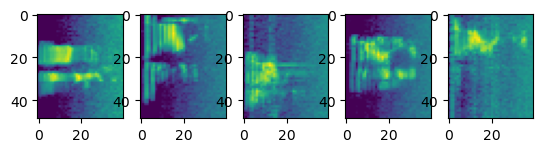

In [26]:
max_target_examples = 5
target_count = 0
target = tf.constant(0)

for dat in ds_train.unbatch():
  # label_string = dat[1].numpy().decode('utf8')
  if dat[1] == target:
    target_count += 1
    plt.subplot(1,max_target_examples, target_count)
    # display.display(display.Audio(dat[0].numpy(), rate=16000))
    plt.imshow(dat[0].numpy())
    if target_count >= max_target_examples:
      break

In [27]:
## look at the label breakdown in the training set
print(count_labels(ds_train))

{2: 83133, 0: 10260, 1: 10000}


## Build and Train Model

In [28]:
model = models.get_model(args=Flags)


DS CNN model invoked
Apple Silicon platform detected. Using legacy adam as standard Keras Adam is slow on this processor.


In [57]:
model.layers[1].get_config()

{'name': 'conv2d',
 'trainable': True,
 'dtype': 'float32',
 'filters': 64,
 'kernel_size': (10, 4),
 'strides': (2, 2),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': {'module': 'keras.regularizers',
  'class_name': 'L2',
  'config': {'l2': 9.999999747378752e-05},
  'registered_name': None},
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [53]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 40, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 25, 20, 64)        2624      
                                                                 
 batch_normalization (Batch  (None, 25, 20, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 25, 20, 64)        0         
                                                                 
 dropout (Dropout)           (None, 25, 20, 64)        0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 25, 20, 64)        640       
 eConv2D)                                                    

In [30]:
callbacks = util.get_callbacks(args=Flags)
train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                       epochs=4)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/4
   1034/Unknown - 127s 123ms/step - loss: 0.1968 - sparse_categorical_accuracy: 0.9527

2024-01-29 10:38:27.719313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16406441438513586254
2024-01-29 10:38:27.719331: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14667202037302532845
2024-01-29 10:38:27.719338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13559676501118744524
2024-01-29 10:38:27.719343: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12381337167286961275
2024-01-29 10:38:27.719349: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6817994950218676073


1034/1034 [==============================] - 130s 126ms/step - loss: 0.1968 - sparse_categorical_accuracy: 0.9527 - val_loss: 4.0339 - val_sparse_categorical_accuracy: 0.0165 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/4
1034/1034 [==============================] - 133s 129ms/step - loss: 0.1957 - sparse_categorical_accuracy: 0.9461 - val_loss: 2.3940 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/4
1034/1034 [==============================] - 132s 128ms/step - loss: 0.1912 - sparse_categorical_accuracy: 0.9503 - val_loss: 12.4950 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005.
Epoch 4/4
1034/1034 [==============================] - 134s 130ms/step - loss: 0.1885 - sparse_categorical_accuracy: 0.9502 - val_loss: 19.6189 - val_sparse_categorical_accuracy: 0.0177 - lr: 5.0000e-

In [50]:
model.save('streaming_ww_model_float.h5')

/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 0, 'Epoch')

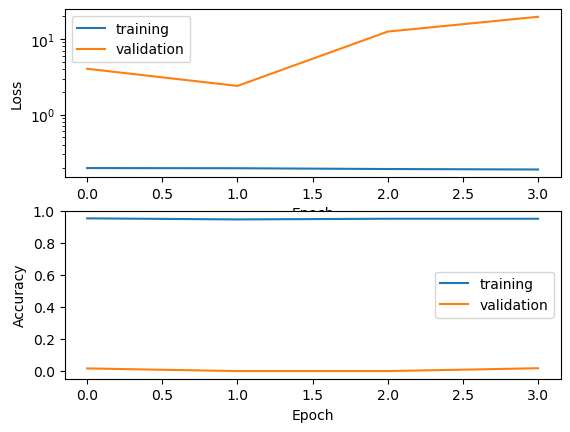

In [34]:
plt.subplot(2,1,1)
plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(train_hist.epoch, train_hist.history['sparse_categorical_accuracy'], train_hist.history['val_sparse_categorical_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


In [36]:

model_out = model.predict(ds_train)
y_pred = np.argmax(model_out, axis=1)

y_true = np.nan*np.zeros(y_pred.shape[0])
for i,dat in enumerate(ds_train.unbatch()):
  y_true[i] = dat[1]

1034/1034 [==============================] - 62s 60ms/step


2024-01-29 10:50:42.789798: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10210027463222765504


In [48]:
label_list = ['marvin', 'silent', 'other']

In [43]:
acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {acc:.1%}')

Test set accuracy: 12.8%


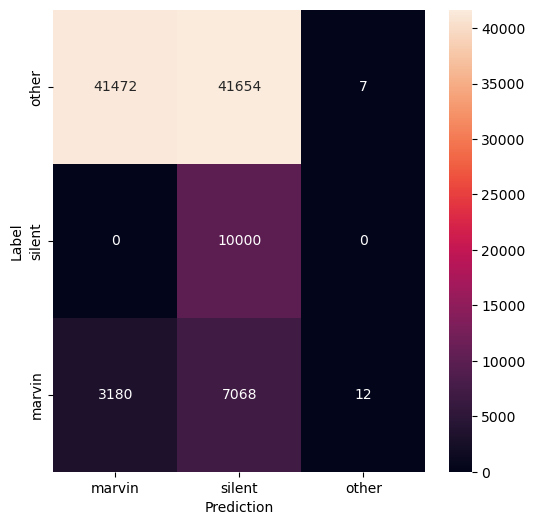

In [49]:

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [45]:
import seaborn as sns